In [1]:
%matplotlib inline

In [2]:
import sys
import os
import argparse
import scipy.stats
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import xesmf as xe
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import regionmask as rm

from global_land_mask import globe
from shapely.geometry import Point
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utils.misc import natural_keys
from dataa.d_config import INDIR, lat_res, lon_res
from cmip6.treat_data.t_config import DATADIR, FIGDIR
from cmip6.treat_data.make_am_series_regridding import load_regridded_amax_series
from cmip6.treat_data.get_valid_models import load_valid_models

Done
Done


In [3]:
### CST ###

cmap = 'viridis_r'
dbffile = './dataa/shapefiles/referenceRegions/referenceRegions.dbf'
cnydbffile = './dataa/shapefiles/World_Continents/World_Continents.dbf'
grid_step = 2.5  # horizontal resolution of new grid (grid_step x grid_step)

ymin_hist = 1993
ymax_ssp = 2022

mems_ = ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1',
'r8i1p1f1', 'r9i1p1f1', 'r10i1p1f1']

In [4]:
#~ Get script parameters

ds = 'CMIP6'
srcs = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR']
ssp_exp = 'ssp245'
nmems = 10
params = ['loc', 'scale']
lat_sub = (-90., 90.)
lon_sub = (-180., 180.)
nd = None  # RX1D / RX7D
q_inf = 0.05  # lower bound of the trends range
q_sup = 0.95  # upper bound of the trends range
nvals = 2  # number of valid models

qs_ = str(q_inf*100) + '-' + str(q_sup*100)

lat_min_ = lat_sub[0]
lat_max_ = lat_sub[1]
lon_min_ = lon_sub[0]
lon_max_ = lon_sub[1]

if lat_max_ - lat_min_ == 20:
    lat_step = 20.
elif lat_max_ - lat_min_ == 180:
    lat_step = 30.

if lon_max_ - lon_min_ == 40:
    lon_step = 20.
elif lon_max_ - lon_min_ == 360:
    lon_step = 60.

if nd:
    nd_ = '_' + str(nd) + 'd'
    nd__ = str(nd)
else:
    nd_ = ''
    nd__ = '1'


#~ Plot params

cmap = plt.get_cmap('RdBu')

ncols_tr = np.linspace(-40., 40., 17)
norm_tr = BoundaryNorm(ncols_tr, ncolors=cmap.N)

xtcks = np.arange(-120., 120+60., 60.)
ytcks = np.arange(-60., 60.+30., 30.)

In [5]:
#~ Get data

df = gpd.read_file(dbffile)
dfcny = gpd.read_file(cnydbffile)
ar6regs = rm.defined_regions.ar6.df[:43]
reg2plot = ar6regs['Name'].values

ams_era5 = load_regridded_amax_series('CMIP6', 'ERA5', 'ssp245', grid_step, ymin_hist, ymax_ssp, 1, nd)

ols_era5 = ams_era5.polyfit(dim='year', deg=1)
slopes = ols_era5.polyfit_coefficients.isel(degree=0)
intercs = ols_era5.polyfit_coefficients.isel(degree=1)
trends_era5 = slopes / (slopes*ymin_hist+intercs) * 10 * 100


out_ams_srcs = []

for src in srcs:
    ams = load_regridded_amax_series(ds, src, ssp_exp, grid_step, ymin_hist, ymax_ssp, nmems, nd)
    out_ams_srcs.append(ams)

out_ams_srcs = xr.concat(out_ams_srcs, dim='GCM')
out_ams_srcs = out_ams_srcs.assign_coords(GCM=srcs)

out_srcs_tr_diff = []

for isrc, src in enumerate(srcs):
    print('\n%s'%src)

    ams_src = out_ams_srcs.sel(GCM=src)
    mems = ams_src.members.values

    out_src_tr_diff = []

    for mem in mems:
        ams_mem = ams_src.sel(members=mem)

        ols_mem = ams_mem.polyfit(dim='time', deg=1)
        slopes_mem = ols_mem.polyfit_coefficients.isel(degree=0)
        intercs_mem = ols_mem.polyfit_coefficients.isel(degree=1)
        trends_mem = slopes_mem / (slopes_mem*ymin_hist+intercs_mem) * 10 * 100

        amax_mem_tr_field_diff = trends_mem - trends_era5
        out_src_tr_diff.append(amax_mem_tr_field_diff)
        
        #print((mem, amax_mem_tr_field_diff.median().values), end=' : ', flush=True)


    out_src_tr_diff = xr.concat(out_src_tr_diff, dim='members')
    out_src_tr_diff = out_src_tr_diff.median(dim='members')

    out_srcs_tr_diff.append(out_src_tr_diff)

lats_LR = out_ams_srcs.lat
lons_LR = out_ams_srcs.lon
lats_ = lats_LR - grid_step / 2
lons_ = lons_LR - grid_step / 2


ACCESS-ESM1-5

CanESM5

IPSL-CM6A-LR

MIROC6

MPI-ESM1-2-LR


<ipython-input-7-62219dcaa61f>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ar6regs.centroid[ireg]
<ipython-input-7-62219dcaa61f>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ar6regs.centroid[ireg]
<ipython-input-7-62219dcaa61f>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = ar6regs.centroid[ireg]
<ipython-input-7-62219dcaa61f>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid =

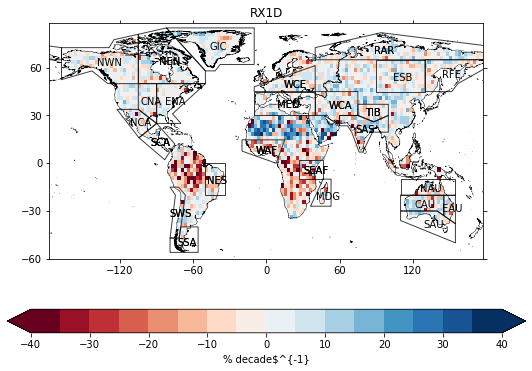

In [7]:
#~ Plot multi-model mean

fig_all, ax_all = plt.subplots()    # Plot maps of RX1D mean diff

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95)

vals_models = load_valid_models(ds=ds, ssp_exp=ssp_exp, grid_step=grid_step, ndays=nd, q_inf=q_inf, q_sup=q_sup)
vals_regs = vals_models.sum(axis=1)
vals_regs = vals_regs[vals_regs >= nvals]

out_srcs_tr_diff = xr.concat(out_srcs_tr_diff, dim='GCM')
out_srcs_tr_diff_mean = out_srcs_tr_diff.median(dim='GCM')

ax_all.pcolor(lons_, lats_, out_srcs_tr_diff_mean.values, norm=norm_tr, cmap=cmap)

ax_all.set_xlim(-178., 178.)
ax_all.set_ylim(-60., 88.)
ax_all.set_xticks(xtcks)
ax_all.set_yticks(ytcks)
ax_all.xaxis.set_ticks_position('both')
ax_all.yaxis.set_ticks_position('both')

for i in dfcny.index:
    pol_cont = gpd.GeoSeries(dfcny.iloc[i]['geometry'])
    pol_cont.boundary.plot(ax=ax_all, linewidth=0.45, color='k', zorder=100)


for reg in reg2plot:
    if reg in vals_regs:
        ireg = ar6regs[ar6regs['Name'] == reg].index[0]
        acronym = ar6regs[ar6regs['Name'] == reg]['Acronym'][ireg]
        pol_reg = gpd.GeoSeries(ar6regs[ar6regs['Name'] == reg]['geometry'])
        pol_reg.boundary.plot(ax=ax_all, linewidth=1., color='k', alpha=0.75)
        centroid = ar6regs.centroid[ireg]
        bounds = ar6regs.iloc[ireg]['geometry'].bounds

    ax_all.text(centroid.x-6.5, centroid.y-3, acronym, zorder=1000)  # , weight=wtxt

#ax_all.text(0.025, 0.025, '{0} % '.format(np.round(out_srcs_tr_diff_mean.median().values, 2)) + ' decade$^{-1}$', transform=ax_all.transAxes)

ax_all.set_title('RX%sD'%nd__)

fig_all.colorbar(mpl.cm.ScalarMappable(norm=norm_tr, cmap=cmap), ax=ax_all, extend='both', orientation='horizontal', label='% decade$^{-1}')

fig_all.set_size_inches(8., 5.5)